<center><b>In the name of God</b></center>

<b>Course</b>: Machine Learning
<br>
<b>Description:</b> HomeWork 1 | Question 3
<br>
<b>Developer</b>: Alireza Mazochi (400131075)

# Libraries

In [1]:
# Import Allowed Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load

In [2]:
train_data = pd.read_csv("train.csv")

In [3]:
test_data = pd.read_csv("test.csv")

In [4]:
set(train_data["region"].values)

{'northeast', 'northwest', 'southeast', 'southwest'}

# Encoding

In [5]:
# Encoding string features

def gender_encoding(gender):
    if gender == "male":
        return 1
    elif gender == "female":
        return 0
    else:
        raise Exception("An expected value for gender!")
    
def smoker_encoding(smoker):
    if smoker == "yes":
        return 1
    elif smoker == "no":
        return 0
    else:
        raise Exception("An expected value for smoker!")

def region_encoding(region):
    if region == "northeast":
        return np.array([1, 0, 0, 0])
    elif region == "northwest":
        return np.array([0, 1, 0, 0])
    elif region == "southeast":
        return np.array([0, 0, 1, 0])
    elif region == "southwest":
        return np.array([0, 0, 0, 1])
    else:
        raise Exception("An expected value for region!")

In [6]:
# Apply encodings

train_data["gender"] = train_data["gender"].apply(gender_encoding)
train_data["smoker"] = train_data["smoker"].apply(smoker_encoding)
train_data["region"] = train_data["region"].apply(region_encoding)

test_data["gender"] = test_data["gender"].apply(gender_encoding)
test_data["smoker"] = test_data["smoker"].apply(smoker_encoding)
test_data["region"] = test_data["region"].apply(region_encoding)

In [7]:
def convert_vector_feature_to_separated_features(data):
    data["region-0"] = data["region"].apply(lambda x:x[0])
    data["region-1"] = data["region"].apply(lambda x:x[1])
    data["region-2"] = data["region"].apply(lambda x:x[2])
    data["region-3"] = data["region"].apply(lambda x:x[3])
    del data["region"]

In [8]:
convert_vector_feature_to_separated_features(train_data)
convert_vector_feature_to_separated_features(test_data)

# Basis Function

In [10]:
train_data["age"] = train_data["age"].apply(lambda x:x**2)
test_data["age"] = test_data["age"].apply(lambda x:x**2)

# Normalization

In [11]:
# Normalization with min-max
train_data=(train_data-train_data.min())/(train_data.max()-train_data.min())
test_data=(test_data-test_data.min())/(test_data.max()-test_data.min())


# X/Y split

In [12]:
x_train = train_data.drop(columns =["charges"]).values
y_train = train_data["charges"].values

x_test = test_data.drop(columns = ["charges"]).values
y_test = test_data["charges"].values

# Multuvariate

In [13]:
class Multivariate():
    """ Class Polynomial store coefficients of a multivariate"""

    def __init__(self, number_variables):
        """ 
        Create a polynomial object.
        
        number_variables: number of variables
        """
        
        self.number_variables = number_variables

        # Coefficients of multivariate: a[n-1]*x[n-1] + a[n-2]*x[n-2] + ... + a[1]*(x[1]) + a[0]*x[0] + c
        self.a = np.zeros(number_variables)
        self.c = 0
        
    def single_apply(self, x):
        """
        Apply the multivariate to a point
        
        x: a point
        """
        return np.dot(x, self.a) + self.c
    
    def apply(self, x):
        """ 
        Apply the multivariate to an array of points
        
        x: array of points
        """
        return np.array(self.single_apply(x))
    
    def set_params(self, a, c):
        """ Setter for params"""
        self.a = a
        self.c = c
    
    def get_params(self):
        """ Getter for params"""
        return self.a, self.c
    
    def __str__(self):
        """ String of the multivariate """
        variables_name = list(train_data.drop(columns = ["charges"]).columns)
        
        output = "charges = "
        for i in range(self.number_variables):
            output += "{:.2f}".format(self.a[i]) + " × " + variables_name[i] + " + "
        
        output += "{:.2f}".format(self.c)
        return output

# Loss Fuction

In [14]:
class LossFunction():
    """ Some Loss functions and partial derivation of them located in this class """

    @staticmethod
    def mse(y_predict, y_real):
        """ Mean Square Error """
        arr = (np.subtract(y_real,y_predict))**2
        return np.sum(arr) / len(y_predict)
    
    @staticmethod
    def partial_mse_a(y_predict, y_real, x, index):
        """ Partial derivation of Mean Square Error for coeficient of feature of multivariat"""
        arr = np.multiply(x[:, index], (np.subtract(y_real, y_predict)))    
        return -2*np.sum(arr)/len(x)
    
    @staticmethod
    def partial_mse_c(y_predict, y_real):
        """ Partial derivation of Mean Square Error for consist coefficient of multivariat"""
        arr = np.subtract(y_real, y_predict) 
        return -2*np.sum(arr)/len(y_real)


# Normal Equation

In [30]:
class MultivariateNormalEquation():
    """ This class try to match a pattern to train data with Normal Equation method """

    def __init__(self, number_features, number_data, lambda_=0):
        """
        Create a MultivariateNormalEquation 
        
        number_features: The number of features
        number_data: The number of data
        lambda_: lamda_ parameter that used for regularization. Defult value ignore regularization.
        """
        self.number_features = number_features
        self.number_data = number_data
        self.lambda_ = lambda_
        self.multivariate = Multivariate(number_variables=number_features)
        
    def _calculate_x(self):
        """ Clalculate the matrix x """
        self.x = []
        for xi_train in x_train[:self.number_data]:
            new_x = [1.0]
            for di in range(self.number_features):
                new_x.append(xi_train[di])
            self.x.append(new_x)
        
        self.x = np.array(self.x)    
    
    def _normal_equation(self):
        """
        Calculate normal equation
        
        Source: http://openclassroom.stanford.edu/MainFolder/DocumentPage.php?course=MachineLearning&doc=exercises/ex5/ex5.html
        """
        xt = np.transpose(self.x)
        xtx = np.matmul(xt, self.x)
        
        lambda_matrix = np.identity(self.number_features + 1) * self.lambda_
        #  Note to source
        lambda_matrix[0, 0] = 0
        xtx += lambda_matrix
        
        xtxi = np.linalg.inv(xtx)
        xty = np.matmul(xt, y_train[:self.number_data])
        c = np.matmul(xtxi, xty)
        self.multivariate.set_params(c[:-1], c[-1])
    
    def plot_result(self):
        """ Plot final prediction """
        print(self.multivariate)
        
        y_predict = self.multivariate.apply(x_train)
        train_mse_error = LossFunction.mse(y_predict, y_train)
        
        y_predict = self.multivariate.apply(x_test)
        test_mse_error = LossFunction.mse(y_predict, y_test)
        
        print(f"Final Train Mean Squared Erorr = {train_mse_error}")
        print(f"Final Test Mean Squared Error = {test_mse_error}")
        
    def test_error(self):
        y_predict = self.multivariate.apply(x_test)
        test_mse_error = LossFunction.mse(y_predict, y_test)
        return test_mse_error
    
    def train_error(self):
        y_predict = self.multivariate.apply(x_train[:self.number_data])
        test_mse_error = LossFunction.mse(y_predict, y_train[:self.number_data])
        return test_mse_error
    
    
    def _configuration_title(self):
        """ Generating a string that contains configurations of the method """
        return f" Numer Features = {self.number_features}"
        
    def run(self):
        """ Run Normal Equation! """
        self._calculate_x()
        self._normal_equation()

In [31]:
multivariate_normal_equation = MultivariateNormalEquation(number_features = len(x_train[0]), number_data=1000, lambda_=0.0001)

In [32]:
multivariate_normal_equation.run()

In [33]:
multivariate_normal_equation.plot_result()

charges = -0.05 × age + 0.20 × gender + -0.00 × bmi + 0.19 × children + 0.04 × smoker + 0.38 × region-0 + 0.01 × region-1 + 0.00 × region-2 + -0.01 × region-3 + -0.01
Final Train Mean Squared Erorr = 0.06954599572931656
Final Test Mean Squared Error = 0.09256216752282292


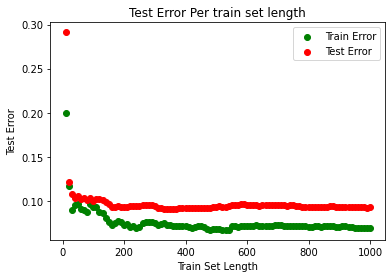

In [37]:
number_data_list = []
test_error_list = []
train_error_list = []

for number_data in range(10,1010,10):
    number_data_list.append(number_data)
    multivariate_normal_equation = MultivariateNormalEquation(number_features = len(x_train[0]), lambda_=0.0001, number_data=number_data)
    multivariate_normal_equation.run()
    test_error = multivariate_normal_equation.test_error()
    train_error = multivariate_normal_equation.train_error()
    train_error_list.append(train_error)
    test_error_list.append(test_error)
    
plt.scatter(x=number_data_list, y=train_error_list, color="green", label="Train Error")
plt.scatter(x=number_data_list, y=test_error_list, color="red", label="Test Error")

plt.xlabel("Train Set Length")
plt.ylabel("Test Error")
plt.title("Test Error Per train set length")
plt.legend()
plt.show()

# Stochastic Gradient Descent

In [38]:
class MultivariateStochasticGradientDescent():
    """ This class try to match a pattern to train data with Stochastic Gradient Descent method """
        
    def __init__(self, number_epoch, number_variables):
        """
        Create a MultivariateStochasticGradientDescent
        
        number_epoch: The required number of epochs
        number_variables: The number of variables        
        """
        
        # Learning rate configuration
        self.learning_rate_initial = 0.005
        self.learning_rate = self.learning_rate_initial
        self.decrease_learning_rate = self.learning_rate_initial / number_epoch
            
        # Array for storing error and learning values 
        self.train_error = []
        self.test_error = []
        self.learning_rate_value = []
    
        self.number_epoch = number_epoch
        
        self.multivariate = Multivariate(number_variables=number_variables)
        
        
    def run(self):
        """ Run Stochastic Gradient Descent! """
        for epoch in range(self.number_epoch):
            self._collect_epoch_statistic(epoch)
            
            # Select one sample randomly
            index = np.random.choice(x_train.shape[0], 1)
            x_train_random = x_train[index]
            y_train_random = y_train[index]
            
            a_new = []
            
            y_predict = self.multivariate.apply(x_train_random)
            
            a_cur, c_cur = self.multivariate.get_params()
            
            for i, ai in enumerate(a_cur):
                ai_new = ai - self.learning_rate * LossFunction.partial_mse_a(y_predict, y_train_random, x_train_random, i)
                a_new.append(ai_new)
            
            c_new = c_cur - self.learning_rate * LossFunction.partial_mse_c(y_predict, y_train_random)
            
            self.multivariate.set_params(np.array(a_new), c_new)
            self.learning_rate -= self.decrease_learning_rate
            
        self._collect_epoch_statistic(epoch)
            
    def _collect_epoch_statistic(self, epoch):
        """ Collect statistics per epoch """
        self.learning_rate_value.append(self.learning_rate)
        
        y_predict = self.multivariate.apply(x_train)
        self.train_error.append(LossFunction.mse(y_predict, y_train))
        
        y_predict = self.multivariate.apply(x_test)
        self.test_error.append(LossFunction.mse(y_predict, y_test))
    
    def plot_result(self):
        """ Plot train error and test error over epochs and predicted equation """
        x = np.arange(0, self.number_epoch+1)
        
        plt.plot(x, self.train_error, color="green", label="Train Error")
        plt.plot(x, self.test_error, color="red", label="Test Error")
        plt.legend()
        plt.title(f"Train Error VS Test Error \n{self._configuration_title()}")
        
        plt.xlabel("Epoch")
        plt.ylabel("Error")
        plt.show()
    
        # Predicted pattern
        print(self.multivariate)
        
        # Final Error Value
        y_predict = self.multivariate.apply(x_train)
        train_error = LossFunction.mse(y_predict, y_train)
        
        y_predict = self.multivariate.apply(x_test)
        test_error = LossFunction.mse(y_predict, y_test)
        
        print()
        print(f"Final Train Error= {train_error}")
        print(f"Final Test Error= {test_error}")
        
    
    def plot_learning_rate_value(self):
        """ Plot changing of the learning rate over epochs """
        x = np.arange(0, self.number_epoch+1)
        
        plt.plot(x, self.learning_rate_value, color = "yellow")
        plt.xlabel("Epoch")
        plt.ylabel("Learning Rate")
        plt.title(f"Learning Rete Changes \n {self._configuration_title()}")
        plt.show()
        
    def _configuration_title(self):
        """ Generating a string that contains configurations of the method """
        return f"Number Epochs = {self.number_epoch}"
    
    

In [39]:
multivariate_stochastic_gradient_descent = MultivariateStochasticGradientDescent(number_epoch = 50000, number_variables = len(x_train[0]))

In [40]:
multivariate_stochastic_gradient_descent.run()

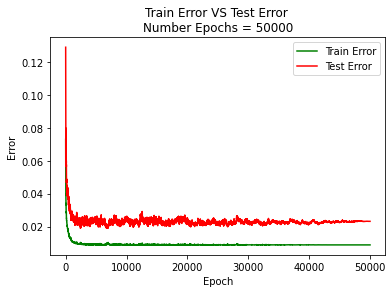

charges = 0.20 × age + -0.01 × gender + 0.19 × bmi + 0.04 × children + 0.38 × smoker + 0.00 × region-0 + -0.01 × region-1 + -0.02 × region-2 + -0.02 × region-3 + -0.04

Final Train Error= 0.008845031940496715
Final Test Error= 0.023170517427375536


In [41]:
multivariate_stochastic_gradient_descent.plot_result()